# Obtain data from netcdf files

In [ ]:
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from cgeniepy.ecology import EcoModel
from cmcrameri import cm
import xarray as xr
from cgeniepy.array import GenieArray

In [21]:
def glob_int_biomass(model, foram):
    """
    integrated foraminifera biomass for one foram ecogroup
    and one model instance
    """
    
    ## m3 in the first layer
    grid_volume = model.grid_volume().isel(zt=0)
    ## mmol C m-3
    foram_biomass = model.get_foram(foram, "Plankton", "C")

    global_biomass = foram_biomass * grid_volume ## mmol C
    ## convert to Pg C
    global_biomass = global_biomass * 12 * 1E-3 * 1E-15

    return global_biomass

def foram_biomass_ts(model_path):
    """
    integrated all foraminifera biomass in each time
    """
    model = EcoModel(model_path)
    time = model.get_var("time").array.values + 0.5
    foram_names = ["bn", "bs", "sn", "ss"]
    data = []
    
    for iyear in range(len(time)):
        state_foram = 0
        for foram in foram_names:
            foram_biomass = glob_int_biomass(model, foram).isel(time=iyear).array.sum()
            state_foram += foram_biomass
        data.append(state_foram)
    return time, data

def sst_ts(model_path):
    "sea surface temperature time series"
    model = EcoModel(model_path)
    time = model.get_var("time").array
    mean_sst, sd_sst = [],[]
    for iyear in range(len(time)):
        mean_sst.append(model.get_var("ocn_sur_temp").isel(time=iyear).mean())
        sd_sst.append(model.get_var("ocn_sur_temp").isel(time=iyear).sd())
    return mean_sst, sd_sst

def get_npp(model_path):    
    d_to_y = 365
    mmol_to_g = 12 * 1E-3
    g_to_Pg = 1E-15
    model = EcoModel(model_path)
    time = model.get_var("time").array
    vol = model.grid_volume().isel(zt=0).array
    data = []
    for iyear in range(len(time)):
        npp_rate = model.get_var("eco2D_Uptake_Fluxes_C").isel(time=iyear).array
        npp_total = np.nansum(npp_rate * vol * d_to_y * mmol_to_g * g_to_Pg)
        data = np.append(data, npp_total)
    return data

def set_theme(base_size=14, base_family="helvetica"):

    custom_params = {
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.grid": True,
        "grid.color": "#f0f0f0",
        "grid.linewidth": 0.5,
        'lines.linewidth': 1,
        'legend.frameon': False,
        'legend.loc': 'lower left',
    }

    sns.set_theme(context='notebook', style='ticks', font=base_family, rc=custom_params)


    font = {
        'family': base_family,
        'weight': 'bold',
        'size': base_size
    }

    plt.rc('font', **font)

    params = {
        'axes.labelsize': base_size,
        'axes.titlesize': base_size,
        'xtick.labelsize': base_size,
        'ytick.labelsize': base_size
    }
    plt.rcParams.update(params)

In [ ]:
## plot pre-industrial age to future
mod_paths = [
    "../model/muffin.CBE.worlg4.BASESFeTDTL.SPIN",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.historical",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.1p5deg",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.2deg",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.3deg",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.4deg",
]

# Store the temporary dataframes in a list
dfs = []

# Iterate over each model path and retrieve the data
for path in mod_paths:
    time_data, biomass_data = foram_biomass_ts(path)
    sst_mean, sst_sd = sst_ts(path)
    npp = get_npp(path)
    # Create a temporary dataframe for each model's data
    temp_df = pd.DataFrame({"time": time_data, "biomass": biomass_data,
                           "sst_mean": sst_mean, "sst_sd": sst_sd,
                            "npp": npp})
    temp_df['age'] = path.split(".")[-1]
    temp_df['age'] = temp_df['age'].str.replace("deg", " °C")
    temp_df['age'] = temp_df['age'].str.replace("1p5", "1.5")

    dfs.append(temp_df)

# Concatenate the dataframes from the list
merged_df = pd.concat(dfs, ignore_index=True)

In [4]:
def get_values(data):
    if isinstance(data, xr.DataArray):
        return data.values.item()
    elif isinstance(data, GenieArray):
        return data.array.values.item()
    else:
        return data
    
## convert xarary to scalar in the data frame
merged_df['biomass'] = merged_df['biomass'].apply(get_values)
merged_df['sst_mean'] = merged_df['sst_mean'].apply(get_values)
merged_df['sst_sd'] = merged_df['sst_sd'].apply(get_values)

## delete rows with time < 1900
merged_df = merged_df[merged_df['time'] > 1900]

## delete 2000, 5000 which are from the SPINUP
merged_df = merged_df[merged_df['time'] != 2000]
merged_df = merged_df[merged_df['time'] != 5000]
## change the time 10000 to 1765
merged_df['time'] = merged_df['time'].replace(10000, 1765)
merged_df['age'] = merged_df['age'].replace('SPIN', 'pre-industrial')

In [5]:
# develop a function to report foram biomass change
def foram_biomass_change(df, age, time1, time2):
    """
    This function takes in a dataframe and an age (e.g. 1.5 °C) and returns the foram biomass change
    """
    biomass1 = df[df['time'] == time1]['biomass'].iloc[-1]
    biomass2 = df[(df['age'] == age) & (df['time'] == time2)]['biomass'].iloc[-1]
    percent_change = (biomass2 - biomass1) / biomass1 * 100
    return percent_change

## example to use the function
foram_biomass_change(merged_df, '1.5 °C', 2022, 2100)

-2.386059701189974

In [6]:
## reference values to compare
ref_biomass = merged_df[merged_df['time'] == 1926.0]['biomass'].iloc[-1]
ref_sst = merged_df[merged_df['time'] == 1926.0]['sst_mean'].iloc[-1]
ref_npp = merged_df[merged_df['time'] == 1926.0]['npp'].iloc[-1]

## remove year=2023 (because the ecogem model does not have restart)
merged_df = merged_df[merged_df['time'] != 2023]

# Calculate biomass change relative to pre-industrial and convert to percentage
merged_df['biomass'] = (merged_df['biomass'] / ref_biomass) * 100 - 100

# Calculate SST change relative to pre-industrial
merged_df['sst_mean'] = merged_df['sst_mean'] -ref_sst

merged_df['npp'] = (merged_df['npp'] / ref_npp) * 100 - 100

## copy the last year of historical to the starting point of future scenarios (only for plotting)
historical_2022 = merged_df[(merged_df['age'] == 'historical') & (merged_df['time'] == 2022)]

result = pd.DataFrame()

# Iterate over unique age categories and append modified rows to result DataFrame
for age_category in merged_df['age'].unique():
    if age_category != 'historical' and age_category != 'pre-industrial':
        modified_df = historical_2022.copy()
        modified_df['age'] = age_category
        result = pd.concat([result, modified_df], ignore_index=True)

merged_df = pd.concat([merged_df, result])        

/Users/yingrui/miniforge3/envs/workspace/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/yingrui/miniforge3/envs/workspace/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/yingrui/miniforge3/envs/workspace/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

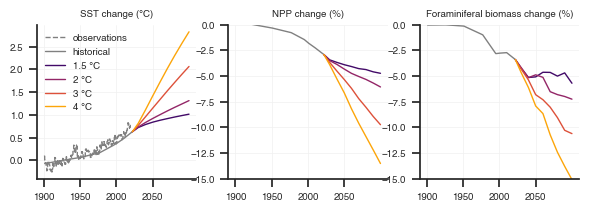

In [29]:
# Plot the data using seaborn
## generate figure
from turtle import width


fig, axs = plt.subplots(figsize=(7, 2), nrows=1, ncols=3, sharex=True)
set_theme(7)

reds_palette = sns.color_palette("inferno", n_colors=4).as_hex()
# Add grey as the first color in the palette
custom_palette = ["#808080"] + reds_palette

axs[1].set(ylim=(-15, 0))
axs[2].set(ylim=(-15, 0))

## donwload from https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/
ersst = xr.open_dataset("../data/sst.mnmean.nc").sst
## get global mean
ersst_gm = ersst.mean(dim=["lat", "lon"])
## plot observation in relative change
ersst_gm = ersst_gm - ersst_gm.sel(time=slice("1900-01-01", "1950-01-01")).mean(dim=["time"])
ersst_gm = ersst_gm.sel(time=slice("1900-01-01", "2020-01-01"))
# plot in rolling mean
ersst_gm = ersst_gm.rolling(time=12).mean()
## extract data for plotting
## time in number
ersst_time = ersst_gm.time.values
ersst_time = ersst_time.astype("datetime64[Y]").astype(int) + 1970

## plot in ax[0]
axs[0].plot(ersst_time, ersst_gm, color="#808080", label="observations", linestyle="--")

## remove year < 1900
merged_df = merged_df[merged_df["time"] >= 1900]
sns.lineplot(data=merged_df, x="time", y="sst_mean", hue="age", ax=axs[0], palette=custom_palette)
sns.lineplot(data=merged_df, x="time", y="npp", hue="age", ax=axs[1], legend=False, palette=custom_palette)
sns.lineplot(data=merged_df, x="time", y="biomass", hue="age", ax=axs[2], legend=False, palette=custom_palette)

## 2020-2023 minus 1970-1980 mean
# now = ersst.sst.sel(time=slice("2020-01-01", "2023-01-01")).mean(dim=["lat", "lon", "time"])
# past = ersst.sst.sel(time=slice("1970-01-01", "1980-01-01")).mean(dim=["lat", "lon", "time"])
# print(now.values)
# print(past.values)

time_x = range(1900, 2100, 50)
## convert to year time format
#time_x = pd.to_datetime(time_x, format="%Y")
for ax in axs:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ## constrcut time ticks
    ax.set_xticks(time_x)

axs[0].legend(title="", fontsize=7, loc='upper left')
axs[0].set_title("SST change (°C)", fontweight='bold', fontsize=7)
axs[1].set_title("NPP change (%)", fontweight="bold", fontsize=7)
axs[2].set_title("Foraminiferal biomass change (%)", fontsize=7)


## export figure
plt.savefig("../output/fig3a.pdf", dpi=300, bbox_inches="tight")

No gemflag is provided, assuming the model includes biogem and ecogem
No gemflag is provided, assuming the model includes biogem and ecogem


/Users/yingrui/miniforge3/envs/workspace/lib/python3.10/site-packages/xarray/core/computation.py:808: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
/Users/yingrui/miniforge3/envs/workspace/lib/python3.10/site-packages/xarray/core/computation.py:808: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)


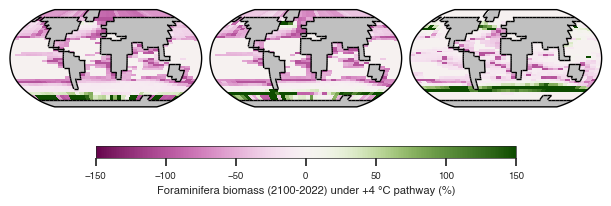

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(6, 2.5),
                        subplot_kw={'projection': ccrs.Robinson()},
                        constrained_layout=True)

modern = EcoModel("../model/muffin.CBE.worlg4.BASESFeTDTL.historical")
future4 = EcoModel("../model/muffin.CBE.worlg4.BASESFeTDTL.2100.4deg")

def array_division(arr1, arr2):
    """
    calculate arr1/arr2 with nan handling
    na/na, return na;
    x/0, return inf, change it to 0;
    small_value/small_value, change it to 0;
    
    :param arr1: array-like 
    :param arr2: array-like
    :return: array-like
    """

    ## avoid nan/nan
    result = np.divide(arr1, arr2)

    result = (result - 1)* 100

    ## if array2 is very samll, set it to zero
    result = np.where(arr2 < 1E-10, 0, result)

    return result


cmap = cm.bam

for i, foramtype in enumerate(["bn", "bs", "ss"]):
    #axs[i].set_title(fnames[i], fontsize=13, fontweight="bold")
    modern_biomass = modern.get_foram(foramtype).isel(time=-1)
    future_biomass = future4.get_foram(foramtype).isel(time=-1)
    diff = xr.DataArray(array_division(future_biomass.array,modern_biomass.array), 
                        dims=modern_biomass.array.dims,
                        coords=modern_biomass.array.coords)
    garray = GenieArray()
    garray.array = diff
    p = garray.plot(ax=axs[i], cmap=cmap, vmin=-150, vmax=150, colorbar=False)    

# Add color bar on the bottom side of the figure
cax = fig.add_axes([0.15, 0.1, 0.7, 0.05])
cbar = fig.colorbar(p, cax=cax, orientation='horizontal', fraction=0.05)
## colorbar border width
cbar.outline.set_linewidth(0.5)

cbar.set_label(r"Foraminifera biomass (2100-2022) under +4 °C pathway (%)", fontsize=8)

# Save the figure
fig.savefig("../output/fig3c.pdf", dpi=300, bbox_inches="tight")